<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/vae_celeba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Variational) Autoencoders with CNNs for CelebA using PyTorch

Based on https://github.com/probml/pyprobml/blob/master/notebooks/vae_celeba_tf.ipynb.
Translated to PyTorch by always-newbie161@ and refactored by murphyk@.



# Setup

In [4]:
import os
import time
import numpy as np
np.random.seed(0)
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display


import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows


In [27]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision.utils import make_grid
from random import randint
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
file = 'vae_helpers_pytorch.py' # change this filename as needed
#!touch $file # create empty file
from google.colab import files
files.view(file) # open editor


<IPython.core.display.Javascript object>

In [6]:
%load_ext autoreload
%autoreload 2

In [32]:
%run $file

In [7]:
!mkdir ./outputs

In [51]:
!ls *.py

vae_helpers_pytorch.py


# Load CelebA

Here we download a zipfile of images and their attributes
that have been preprocessed to 64x64 using the script at
https://github.com/probml/pyprobml/blob/master/scripts/celeba_kaggle_preprocess.py



In [9]:
# N can be 200, 20000, or 40000
N = 20000
H = 64; W = 64; C = 3;
input_shape = [H, W, 3]
name = 'celeba_small_H{}_W{}_N{}'.format(H, W, N)
csv_name = '{}.csv'.format(name)
zip_name = '{}.zip'.format(name)

In [10]:
!rm {csv_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{csv_name}  

rm: cannot remove 'celeba_small_H64_W64_N20000.csv': No such file or directory
--2021-06-29 19:14:08--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2440084 (2.3M) [text/plain]
Saving to: ‘celeba_small_H64_W64_N20000.csv’

celeba_small_H64_W6 100%[===================>]   2.33M  --.-KB/s    in 0.05s   

2021-06-29 19:14:09 (47.5 MB/s) - ‘celeba_small_H64_W64_N20000.csv’ saved [2440084/2440084]



In [11]:
df = pd.read_csv(csv_name)
df.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,...,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [12]:
print(list(df.columns))

['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [13]:
N = len(df)
print(N)

20000


In [14]:
!rm {zip_name}
!wget https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/{zip_name}
  

rm: cannot remove 'celeba_small_H64_W64_N20000.zip': No such file or directory
--2021-06-29 19:14:25--  https://raw.githubusercontent.com/probml/pyprobml/master/data/CelebA/celeba_small_H64_W64_N20000.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34148268 (33M) [application/zip]
Saving to: ‘celeba_small_H64_W64_N20000.zip’

celeba_small_H64_W6 100%[===================>]  32.57M  98.2MB/s    in 0.3s    

2021-06-29 19:14:27 (98.2 MB/s) - ‘celeba_small_H64_W64_N20000.zip’ saved [34148268/34148268]



In [15]:
!rm *.jpg
!ls

rm: cannot remove '*.jpg': No such file or directory
celeba_small_H64_W64_N20000.csv  outputs      vae_helpers_pytorch.py
celeba_small_H64_W64_N20000.zip  sample_data


In [16]:
!unzip -qq {zip_name}

In [17]:
from glob import glob
filenames = glob('*.jpg')
#print(filenames) # should match df['image_id']
print(len(filenames))

20000


In [18]:
# we read all the images into memory for simplicity
from matplotlib.image import imread
images_celeba = np.zeros((N, H, W, C), dtype=np.float32) # pre-allocate memory
for i in range(N):
    filename = df.iloc[i]['image_id']
    img = imread(filename) # numpy array of uint8
    images_celeba[i,:,:,:] = img / 255

In [19]:
# dataset wrapper around the numpy array of images
# we resize to 32x32 for speed
class Celeba_ds(Dataset):

  def __init__(self, images):
    self.X = images

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
        image = self.X[index]
        X = self.transform(image)
        return X
  
  transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])



In [22]:
celeba_dataset = Celeba_ds(images_celeba)
celeba_train_loader = DataLoader(
        celeba_dataset,batch_size= 32,shuffle=False)



In [26]:
for batch in celeba_train_loader:
  x = batch
  print(x.shape)
  break

Xsmall = next(iter(celeba_train_loader))[0,:]
print(Xsmall.shape)

torch.Size([32, 3, 32, 32])
torch.Size([3, 32, 32])


In [38]:
print(len(celeba_dataset))
print(len(celeba_train_loader))
print(celeba_train_loader.batch_size)
print(celeba_train_loader.batch_size * len(celeba_train_loader))

20000
625
32
20000


# Model

In [132]:
encoder_conv_filters=[32,64,64, 64]
decoder_conv_t_filters=[64,64,32,3]

models_celeba = {}
models_celeba['200d-stoch'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,
                                      200,'200d-stoch',device).to(device)
models_celeba['200d-det'] = ConvVAE(Xsmall.shape,encoder_conv_filters,decoder_conv_t_filters,
                                    200,'200d-det',device,deterministic=True).to(device)
summary(models_celeba['200d-det'],Xsmall.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         LeakyReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         LeakyReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          36,928
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 2, 2]          36,928
      BatchNorm2d-11             [-1, 64, 2, 2]             128
        LeakyReLU-12             [-1, 64, 2, 2]               0
           Linear-13                  [-1, 200]          51,400
        LeakyReLU-14                  [

# Training

## Callback

In [139]:
images_to_recon = next(iter(celeba_train_loader)) # first batch
nimages = 6
images_to_recon = images_to_recon[:nimages,:,:,:]
display_every_n_epochs = 1

def callback(model, epoch, train_epoch_loss, valid_epoch_loss):
  #display.clear_output(wait=False) # don't erase old outputs
  print(f"Training Losses on epoch {epoch}"); print(train_epoch_loss)
  print(f"Validation Losses on epoch {epoch}"); print(valid_epoch_loss)
  if epoch % display_every_n_epochs == 0:
    samples = model.generate_images(nimages)
    recon = model.reconstruct_images(images_to_recon)
    show_images(samples, ttl='samples')
    show_images(images_to_recon, ttl='input')
    show_images(recon, ttl='reconstruction')
    plt.show()

In [118]:
print(type(images_to_recon[0]))

<class 'torch.Tensor'>


In [131]:
%run 'vae_helpers_pytorch.py'

<Figure size 432x288 with 0 Axes>

## AE

Training Losses on epoch 0
{'loss': 55841.8242125, 'nll-loss': 55841.8242125, 'kl-loss': 0.0}
Validation Losses on epoch 0
{'loss': 53883.99453125, 'nll-loss': 53883.99453125, 'kl-loss': 0.0}
Training Losses on epoch 1
{'loss': 54244.87743125, 'nll-loss': 54244.87743125, 'kl-loss': 0.0}
Validation Losses on epoch 1
{'loss': 53135.1323, 'nll-loss': 53135.1323, 'kl-loss': 0.0}


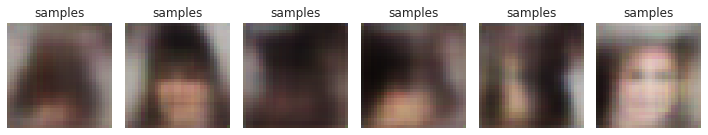

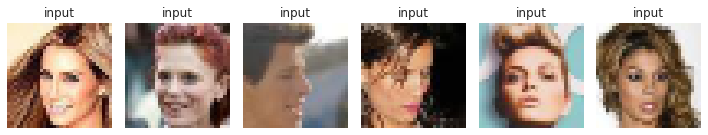

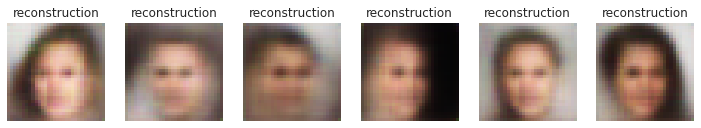

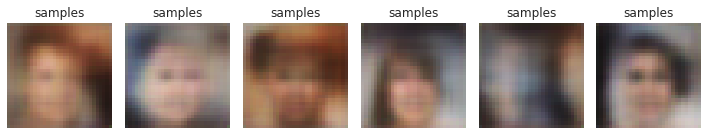

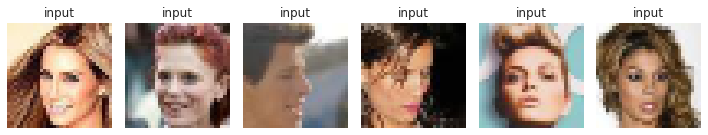

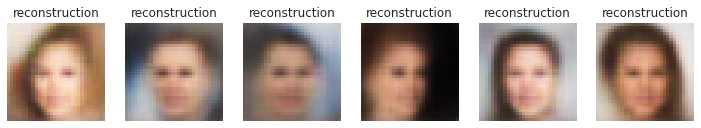

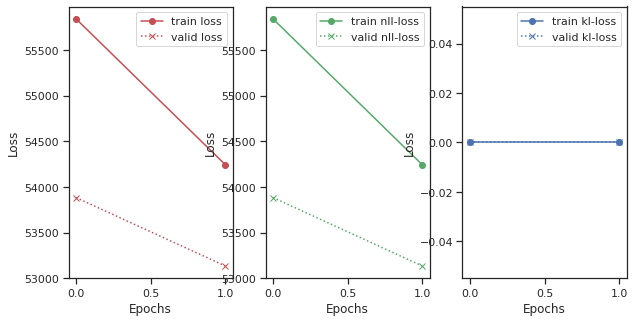

In [134]:
epochs = 2
lr = 0.001
optimizer = torch.optim.Adam(models_celeba['200d-det'].parameters(), lr=lr)
train_loss, valid_loss = training(models_celeba['200d-det'], celeba_train_loader, celeba_test_loader,
                     optimizer, epochs, callback=callback)
fig, axs = plot_loss_histories(train_loss, valid_loss)
plt.show()

## VAE

Training Losses on epoch 0
{'loss': 59549.13935625, 'nll-loss': 58491.88625, 'kl-loss': 1057.2530916015626}
Validation Losses on epoch 0
{'loss': 57443.57815625, 'nll-loss': 56443.1610375, 'kl-loss': 1000.4171055664062}


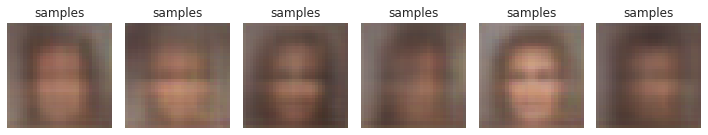

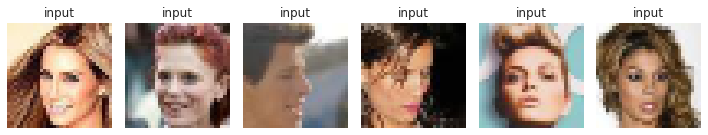

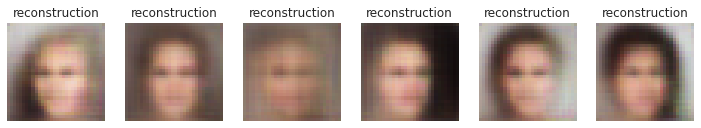

Training Losses on epoch 1
{'loss': 58018.50566875, 'nll-loss': 56844.28606875, 'kl-loss': 1174.2196100585938}
Validation Losses on epoch 1
{'loss': 56994.464725, 'nll-loss': 55941.315575, 'kl-loss': 1053.1491547851563}


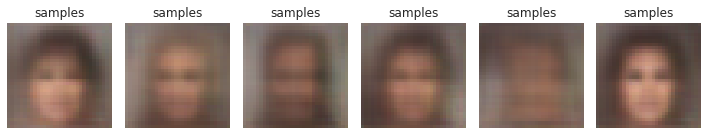

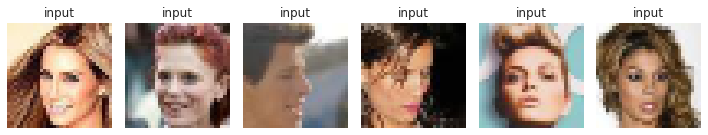

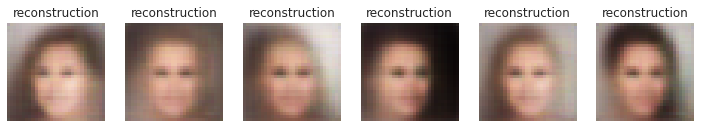

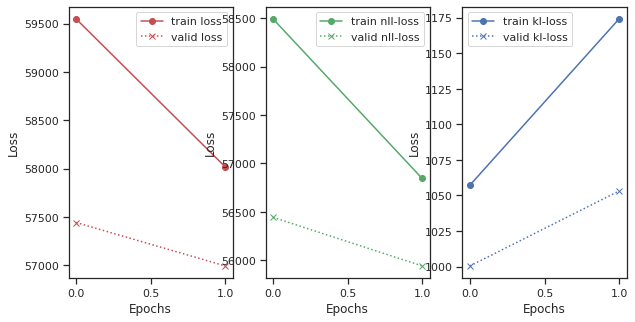

TypeError: ignored

In [140]:
epochs = 2
lr = 0.001
optimizer = torch.optim.Adam(models_celeba['200d-stoch'].parameters(), lr=lr)
train_loss, valid_loss = training(models_celeba['200d-stoch'], celeba_train_loader, celeba_test_loader,
                     optimizer, epochs, callback=callback)
fig, axs = plot_loss_histories(train_loss, valid_loss)
plt.show()



# Reconstructions

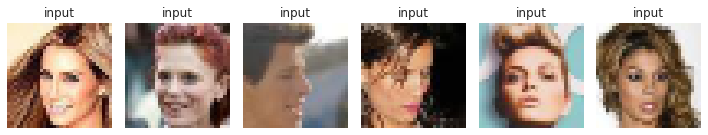

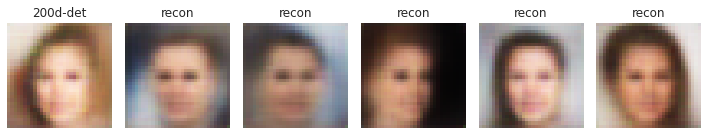

In [136]:
name = '200d-det'
model = models_celeba[name]
recon = model.reconstruct_images(images_to_recon)
fig, axs = show_images(images_to_recon, ttl='input')
fig, axs = show_images(recon, ttl='recon')
axs[0].set_title(name)
plt.show()

# Samples

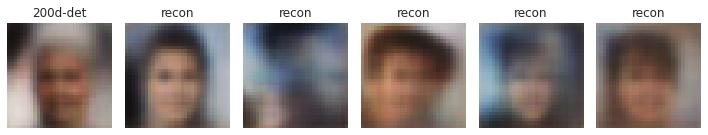

In [138]:
name = '200d-det'
model = models_celeba[name]
samples = model.generate_images(num_images=6)
fig, axs = show_images(samples, ttl='sample')
axs[0].set_title(name)
plt.show()

# Latent space analysis

Illustrate latent space embedding and arithmetic for  VAE on CelebA faces images
Code is based on 
 https://nbviewer.jupyter.org/github/davidADSP/GDL_code/blob/master/03_06_vae_faces_analysis.ipynb

In [142]:
# Make some wrapper functions so we can reuse code from
# https://github.com/davidADSP/GDL_code/blob/master/03_03_vae_faces_analysis.ipynb
  
N, H, W, C = images_celeba.shape
input_shape = (H,W,C)
INPUT_DIM = input_shape
DATA_FOLDER = ''
IMAGE_FOLDER = ''

def vae_encode(model, x):
    z,_ = model.encode(x)
    return z

def vae_decode(model, z_points):
    return model.decode(z_points)


In [143]:
print(input_shape)

(64, 64, 3)


In [144]:
att = pd.read_csv(csv_name)
att.head()


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,...,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [145]:
class ImageLabelLoader():
  def __init__(self, image_folder, target_size):
    self.image_folder = image_folder
    self.target_size = target_size
  
  def build(self, att, batch_size, label = None):

    if label:
      images_celeba,labels = self.get_images(att,label)
      data_loader = DataLoader(Celeba_ano_ds(images_celeba,labels),batch_size= batch_size,shuffle=True)
    else:
      images_celeba = self.get_images(att)
      data_loader = DataLoader(Celeba_ds(images_celeba),batch_size= batch_size,shuffle=True)
      
    return data_loader

  def get_images(self,df,label=None):
    H,W,C = self.target_size
    images = np.zeros((len(df), H, W, C), dtype=np.float32) # pre-allocate memory
    labels = np.zeros(len(df))
    for i in range(N):
      filename = df.iloc[i]['image_id']
      img = imread(filename) # numpy array of uint8
      images[i,:,:,:] = img / 255
      if label:
        labels[i]= df.iloc[i][label]
    if label:
      return images,labels
    else:
      return images


imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM)

## Arithmetic in latent space

In [153]:


def get_vector_from_label(model, label, batch_size=500, att=att):
    latent_dim = model.latent_dim
    data_loader = imageLoader.build(att, batch_size, label = label)

    #origin = np.zeros(shape = latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = latent_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')

    while(current_n_POS < 1000):

        batch = next(iter(data_loader))
        im = batch[0].to(device)
        attribute = batch[1]
        
        z = vae_encode(model, im)

        z = z.cpu().detach().numpy()
        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   




In [154]:
def add_vector_to_images(example_images, model, feature_vec, att=att):
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])
    n_to_show = len(example_images)
    input = torch.zeros(n_to_show, C, 32, 32)
    for i in range(n_to_show):
        input[i,:,:,:] = transform(example_images[i])
    input = input.to(device)
    z_points = vae_encode(model, input)
    z_points = z_points.cpu().detach()
    for i in range(n_to_show):
      fig = plt.figure(figsize=(18, 8))
      counter = 1
      img = example_images[i].squeeze()
      sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
      sub.axis('off')        
      sub.imshow(img)
      counter += 1
      for factor in factors:
          changed_z_point = z_points[i] + feature_vec * factor
          changed_z_point = changed_z_point.to(device)
          changed_image = vae_decode(model, changed_z_point[None,:])[0]
          img = changed_image.cpu().detach()
          sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
          sub.axis('off')
          sub.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:, :, :])
          counter += 1
      return fig

## Experiments

Modifying Eyeglasses using 200d-det
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
Found the Eyeglasses vector
Modifying Eyeglasses using 200d-stoch
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
Found the Eyeglasses vector
Modifying Male using 200d-det
label: Male
images : POS move : NEG move :distance : 𝛥 distance
Found the Male vector
Modifying Male using 200d-stoch
label: Male
images : POS move : NEG move :distance : 𝛥 distance
Found the Male vector


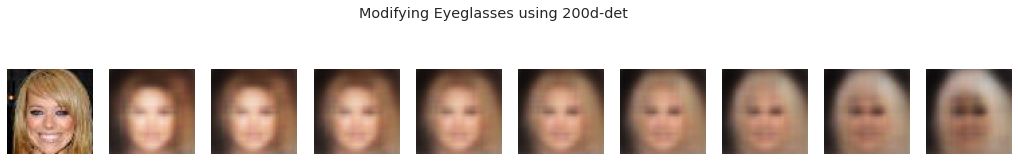

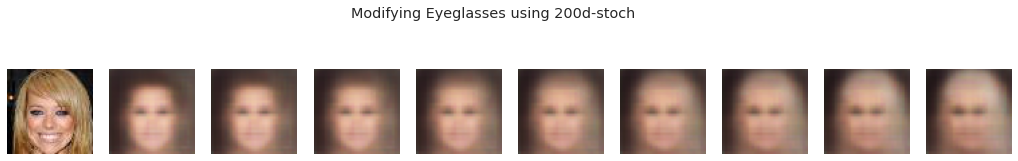

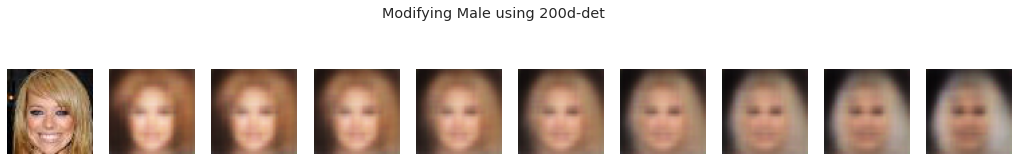

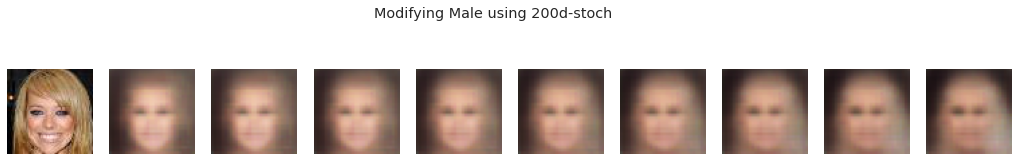

In [156]:
attributes = ['Eyeglasses', 'Male']
img_ndx = [112-1, 258-1, 238-1, 193-1] # blonde, black hair, brunette, male with glasses
img_ndx = [238-1, 193-1] # brunette, male with glasses
model_names = ['200d-det', '200d-stoch']
for att_ndx, att in enumerate(attributes):
  for name_ndx, name in enumerate(model_names):
    ttl = f"Modifying {att} using {name}"
    print(ttl)
    model = models_celeba[name]
    vec = get_vector_from_label(model, att)
    fig = add_vector_to_images(images_celeba[ndx], model, vec)
    fig.suptitle(ttl, y=0.8)
    plt.show()

## Face interpolation

In [ ]:
def morph_faces(start_image, end_image, model):
    #factors = np.arange(0, 1, 0.1)
    factors = np.arange(0, 1, 0.2)
    example_images = np.stack( (start_image, end_image), 0)
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        ])
    n = len(example_images)
    input = torch.zeros(n, C, 32, 32)
    for i in range(n):
        input[i,:,:,:] = transform(example_images[i])

    input = input.to(device)
    z_points = vae_encode(model, input)

    fig = plt.figure(figsize=(18, 8))

    counter = 1
    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1
    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_z_point = changed_z_point.to(device)
        changed_image = vae_decode(model, changed_z_point[None,:])[0]
        img = changed_image.cpu().detach()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(torch.transpose(torch.transpose(img,0,2),0,1)[:, :, :])

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()


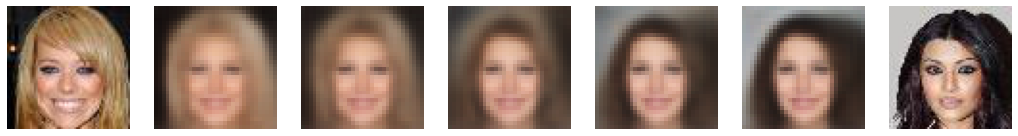

In [ ]:
#model = model_dict_celeba['200d_stoch']
model = model_dict_celeba['200d_det']

start_image = images_celeba[112-1] # blonde
end_image = images_celeba[258-1] # brunette
morph_faces(start_image, end_image, model)

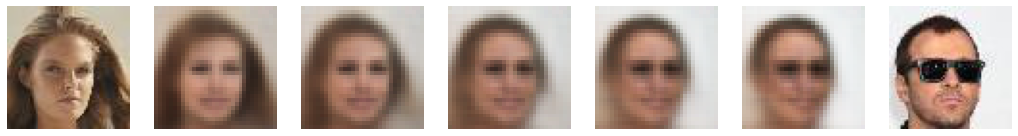

In [ ]:
start_image = images_celeba[238-1] #female
end_image = images_celeba[193-1]  #male, glasses
morph_faces(start_image, end_image, model)